In [1]:
from pathlib import Path
from math import floor,log10
import json
from src.data_structures import Instance
from matplotlib import pyplot as plt
import numpy as np
from itertools import groupby
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [2]:
#Cargo las instancias, y los resultados desde cada carpeta, y los combino
results_path = Path("final_results")
baldo_data_path = Path("baldo_test_data")
files = results_path.iterdir()
names_to_use = [file.name for file in files]
instances = [] 
for file in names_to_use:
    instance = Instance.from_file(baldo_data_path/file)
    instance.file_name = file
    instances.append(instance)
    result = open(results_path/instance.file_name,"r")
    result_data = json.load(result)
    result.close()
    instance.result = result_data
instances.sort(key=lambda x: x.n_items)

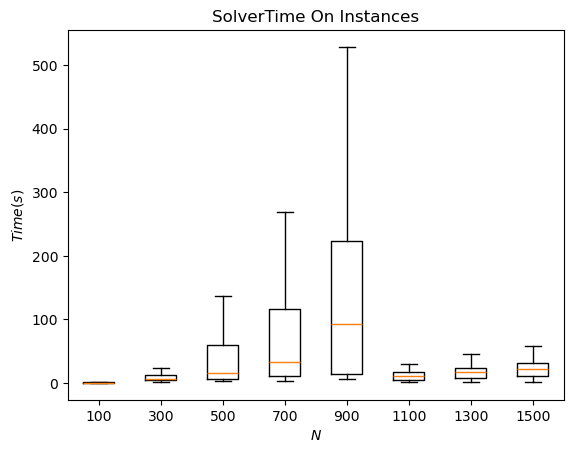

In [3]:
a = groupby(instances,key=lambda ins: ins.n_items)
todo = []
for key,group in a:
    points = [instance.result['Solver_time'] for instance in group]
    todo.append(points)
plt.title("SolverTime On Instances")
a = plt.boxplot(todo,showfliers=False)
plt.ylabel(r"$Time(s)$")
plt.xlabel(r"$N$")
_ = plt.xticks([i+1 for i in range(8)],[str(100 + i*200) for i in range(8)])
plt.savefig("assets/solver_times.png")
    


In [4]:
matrix = []
for instance in instances:
    if instance.result["Solver_of"] == -1:
        continue
    #if instance.result["BaldoML_of"] == -1:
    #    continue
    sol_of = instance.result["Solver_of"]
    sol_time = instance.result["Solver_time"] + 1
    gap = lambda instance,x: ((instance.result["Solver_of"]-instance.result[x])/instance.result["Solver_of"])*100
    points = []
    points.append((gap(instance,f"BaldoGA_of"),(instance.result[f"BaldoGA_time"])))
    points.append((gap(instance,f"BaldoML_of"),(instance.result[f"BaldoML_time"])))
    for i in range(1,11):
        threshold = round(0.05*i,3)
        points.append((gap(instance,f"Z_threshold{threshold}_of"),(instance.result[f"Z_threshold{threshold}_time"])))
    matrix.append(points)


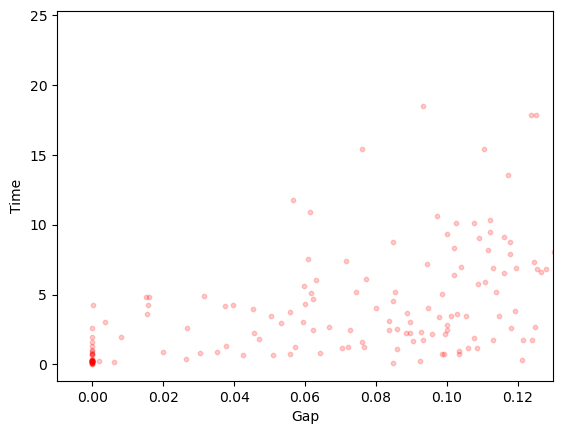

In [5]:
#plt.legend(loc="upper right")
plt.xlabel("Gap")
plt.ylabel("Time")
plt.xlim(-0.01,0.13)


matrix = np.array(matrix)
i = 1
plt.scatter(matrix[:,11,0],matrix[:,11,1],alpha=0.2,color ="blue",s=10)
plt.scatter(matrix[:,2,0], matrix[:,2,1],alpha=0.2,color ="red",s=10)

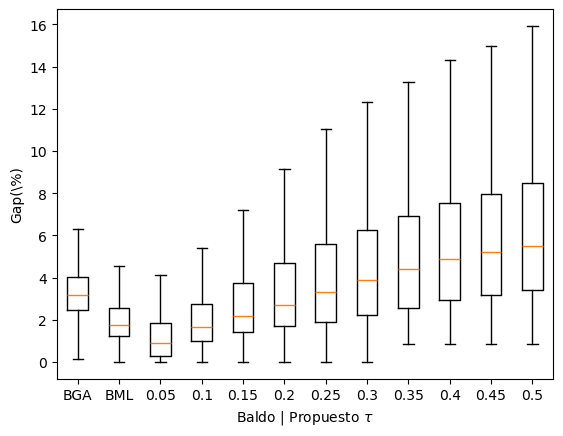

In [6]:
#Boxplot del Gap con distintos Tau y otros metodos
#matrix[instance,solver,gap]
bplot = plt.boxplot(matrix[:,:,0],showfliers=False)
plt.xticks([i for i in range(1,13)],["BGA","BML"]+[str(round(i*0.05,3)) for i in range(1,11)])
plt.ylabel(r"Gap(\%)")
plt.title("")
plt.rc("text",usetex=True)
plt.xlabel(r'Baldo | Propuesto $\tau$')
plt.savefig("assets/full_gap_comparison.png")

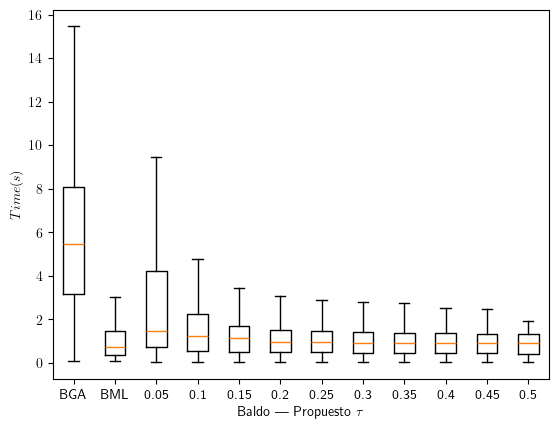

In [7]:
#Boxplot del TimeGap con distintos tau
#matrix[instance,solver,gap]
bplot = plt.boxplot(matrix[:,:,1],showfliers=False)
plt.xticks([i for i in range(1,13)],["BGA","BML"]+[str(round(i*0.05,3)) for i in range(1,11)])
plt.ylabel(r"$Time(s)$")
plt.rc("text",usetex=True)
plt.xlabel(r'Baldo | Propuesto $\tau$')
plt.savefig("assets/full_time_comparison.png")


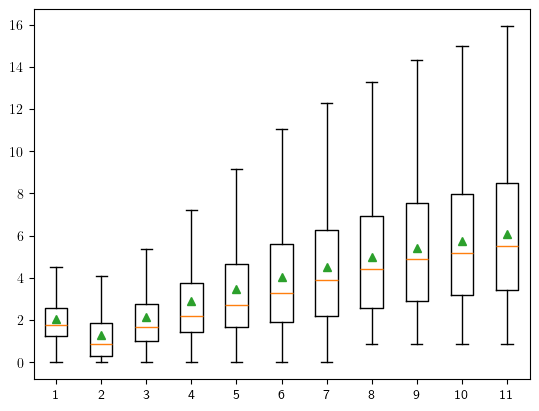

In [24]:
bplot = plt.boxplot(matrix[:,1:,0],showfliers=False,showmeans=True)


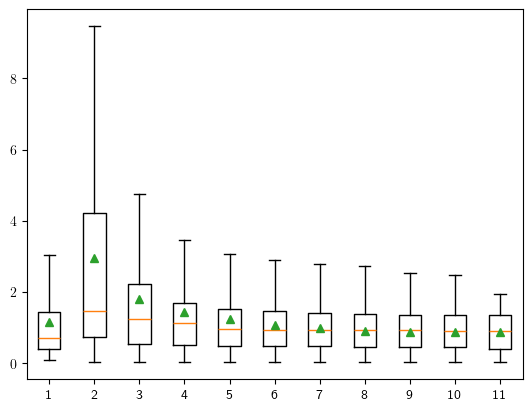

In [25]:
bplot = plt.boxplot(matrix[:,1:,1],showfliers=False,showmeans=True)

In [8]:
from itertools import groupby

def by_size_performance(metodo: str,plot=True):
    by_size_instances = groupby(instances,key=lambda ins: ins.n_items)
    sizes = []
    keys  = []
    for key, group in by_size_instances:
        points = []
        keys.append(key)
        for instance in group:
            if instance.result["Solver_of"] == -1:
                continue
            sol_of = instance.result["Solver_of"]
            sol_time = instance.result["Solver_time"] + 1
            gap = lambda instance,x: ((instance.result["Solver_of"]-instance.result[x])/instance.result["Solver_of"])*100
            points.append((gap(instance,f"{metodo}_of"),(instance.result[f"{metodo}_time"])))
        sizes.append(np.array(points))
    data_to_plot = [points[:,0] for points in sizes]
    if plot:
        boxplot = plt.boxplot(data_to_plot,showfliers=False)
    return sizes



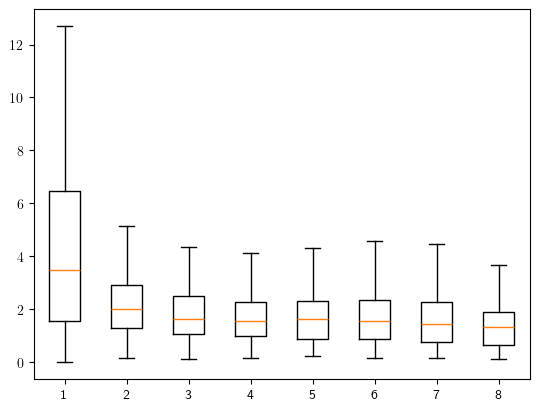

In [9]:
sizes = by_size_performance(f"Z_threshold0.1")



In [10]:
#Listas de gaps

gap_type = 0 #1 es time 0 es optimality gap
metodo = "BaldoML"
types = ["Gap","Time"]
print(metodo,types[gap_type])
for i in range(8):
    points = by_size_performance(metodo,plot = False)[i][:,gap_type]
    name = f"{100 +200*i }: "
    mean = np.average(points)
    mean = round_sig(mean,3)
    if mean < 0.001:
        mean = "{:.3e}".format(mean)
    std =  np.std(points)

    if gap_type == 0:
        std = std
    std = round_sig(std,3)
    if std < 0.01:
        std = "{:.3e}".format(std)

    print(name+ f"Mean: {mean} Std: {std}")
    
    

BaldoML Gap
100: Mean: 3.16 Std: 1.87
300: Mean: 3.0 Std: 1.19
500: Mean: 2.2 Std: 0.907
700: Mean: 2.0 Std: 0.722
900: Mean: 1.85 Std: 0.659
1100: Mean: 1.41 Std: 0.56
1300: Mean: 1.37 Std: 0.592
1500: Mean: 1.39 Std: 0.497


In [11]:
#Listas de gaps

gap_type = 1 #1 es time 0 es optimality gap
metodos = ['Z_threshold0.05',
            'Z_threshold0.1',
            'Z_threshold0.15',
            'Z_threshold0.2',
            'Z_threshold0.25',
            'Z_threshold0.3',
            'Z_threshold0.35',
            'Z_threshold0.4',
            'Z_threshold0.45',
            'Z_threshold0.5',
            ]
for metodo in metodos:
    for gap_type in range(2):
        types = ["Gap","Time"]
        print(metodo,types[gap_type])
        for i in range(8):
            points = by_size_performance(metodo,plot = False)[i][:,gap_type]
            name = f"{100 +200*i }: "
            mean = np.average(points)
            mean = round_sig(mean,3)
            if mean < 0.001:
                mean = "{:.3e}".format(mean)
            std =  np.std(points)

            if gap_type == 0:
                std = std * 100
            std = round_sig(std,3)
            if std < 0.01:
                std = "{:.3e}".format(std)

            print(name+ f"Mean: {mean} Std: {std}")

Z_threshold0.05 Gap
100: Mean: 2.48 Std: 248.0
300: Mean: 1.34 Std: 108.0
500: Mean: 1.12 Std: 92.2
700: Mean: 1.09 Std: 86.8
900: Mean: 1.14 Std: 99.6
1100: Mean: 1.12 Std: 101.0
1300: Mean: 1.02 Std: 96.5
1500: Mean: 0.839 Std: 83.7
Z_threshold0.05 Time
100: Mean: 0.138 Std: 0.104
300: Mean: 0.665 Std: 0.391
500: Mean: 1.32 Std: 0.874
700: Mean: 2.46 Std: 1.74
900: Mean: 4.08 Std: 2.98
1100: Mean: 3.43 Std: 2.8
1300: Mean: 4.84 Std: 3.83
1500: Mean: 6.68 Std: 4.69
Z_threshold0.1 Gap
100: Mean: 4.2 Std: 317.0
300: Mean: 2.19 Std: 118.0
500: Mean: 1.89 Std: 114.0
700: Mean: 1.87 Std: 130.0
900: Mean: 1.92 Std: 133.0
1100: Mean: 1.85 Std: 130.0
1300: Mean: 1.8 Std: 135.0
1500: Mean: 1.58 Std: 119.0
Z_threshold0.1 Time
100: Mean: 0.0914 Std: 0.0735
300: Mean: 0.511 Std: 0.281
500: Mean: 0.929 Std: 0.562
700: Mean: 1.6 Std: 0.848
900: Mean: 2.5 Std: 1.52
1100: Mean: 2.07 Std: 1.7
1300: Mean: 2.84 Std: 2.12
1500: Mean: 3.88 Std: 3.11
Z_threshold0.15 Gap
100: Mean: 5.65 Std: 336.0
300: Mean

In [12]:
assets = Path("assets")
nombres = {'BaldoML':'BaldoML',
           'BaldoGA':'BaldoGA',
           'Z_threshold0.05': r"Propuesto $\tau=0.05$",
           'Z_threshold0.1': r"Propuesto $\tau=0.1$",
           'Z_threshold0.15': r"Propuesto $\tau=0.15$",
           'Z_threshold0.2': r"Propuesto $\tau=0.2$",
           'Z_threshold0.25': r"Propuesto $\tau=0.25$",
           'Z_threshold0.3': r"Propuesto $\tau=0.3$",
           'Z_threshold0.35': r"Propuesto $\tau=0.35$",
           'Z_threshold0.4': r"Propuesto $\tau=0.4$",
           'Z_threshold0.45': r"Propuesto $\tau=0.45$",
           'Z_threshold0.5': r"Propuesto $\tau=0.5$",
           }

tipos = [r"$Gap(\%)$",r"$Time(s)$"]
file_tipe_names = ["gap","time"]
metodos = list(nombres.values())
valores = list(nombres.keys())
for tipo in range(2):
    for metodo in range(len(metodos)):
        sizes = by_size_performance(valores[metodo],plot = False)
        plt.title(metodos[metodo])
        plt.ylabel(tipos[tipo])
        plt.xlabel(r"$N$")
        data_to_plot = [points[:,tipo] for points in sizes]
        _ = plt.boxplot(data_to_plot,showfliers=False)
        _ = plt.xticks([i+1 for i in range(8)],[str(100 + i*200) for i in range(8)])
        plt.savefig(assets/f"{valores[metodo]}_{file_tipe_names[tipo]}.png")
        plt.clf()

<Figure size 640x480 with 0 Axes>